# DualViewHair: Two-View Augmentation Visualization

This notebook demonstrates the core concept behind **DualViewHair** dual-view learning using example images:
- **View A (Teacher)**: Segmented object only (dog_removed_background.png)
- **View B (Student)**: Full image with background (dog_full_image.jpeg)

## Concept Overview
In DualViewHair, we train a model using asymmetric dual views:
1. **Hair-only images** (like segmented dog) provide clean, focused features
2. **Full portrait images** (like full dog image) contain the target + distractions
3. **Contrastive learning** aligns these views to learn robust hairstyle representations

Let's visualize how augmentations are applied to both views while maintaining their correspondence!

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import torchvision.transforms as transforms
import torch
import random
from pathlib import Path

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries imported successfully!")
print("📋 Available transforms:", dir(transforms)[:10], "...")

✅ Libraries imported successfully!
📋 Available transforms: ['AugMix', 'AutoAugment', 'AutoAugmentPolicy', 'CenterCrop', 'ColorJitter', 'Compose', 'ConvertImageDtype', 'ElasticTransform', 'FiveCrop', 'GaussianBlur'] ...


✅ Full image loaded: (863, 625)
✅ Segmented image loaded: (587, 425)


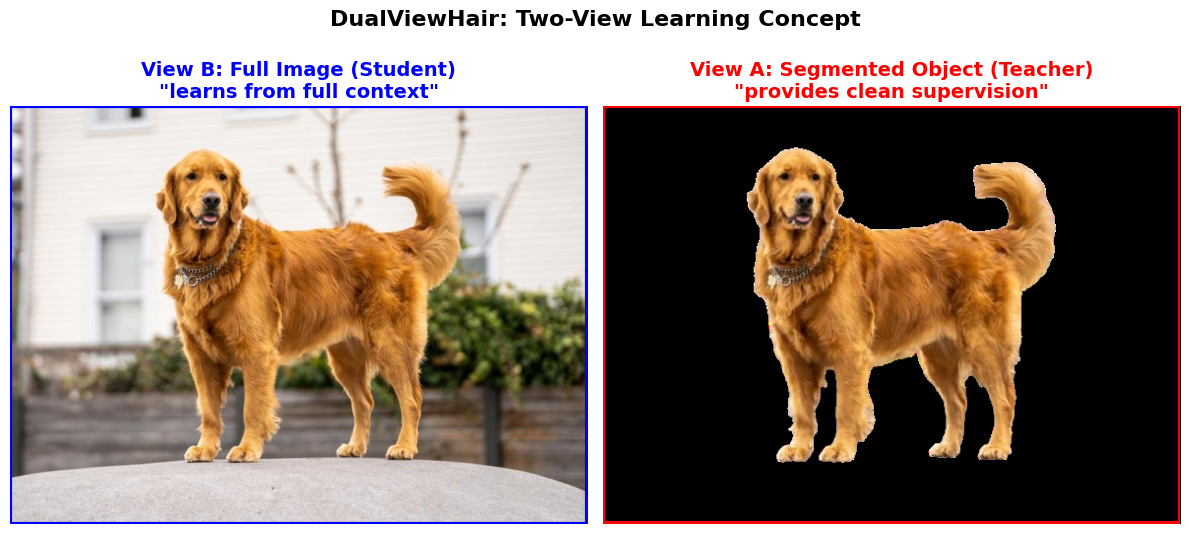

In [2]:
# Load and Display Original Images
try:
    # Load the two view images
    full_image = Image.open("dog_full_image.jpeg").convert('RGB')
    segmented_image = Image.open("dog_removed_background.png").convert('RGB')
    
    print(f"✅ Full image loaded: {full_image.size}")
    print(f"✅ Segmented image loaded: {segmented_image.size}")
    
    # Create side-by-side visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display full image (View B - Student)
    axes[0].imshow(full_image)
    axes[0].set_title('View B: Full Image (Student)\n"learns from full context"', 
                     fontsize=14, fontweight='bold', color='blue')
    axes[0].axis('off')
    axes[0].add_patch(plt.Rectangle((0, 0), full_image.width-1, full_image.height-1, 
                                   fill=False, edgecolor='blue', linewidth=3))
    
    # Display segmented image (View A - Teacher)  
    axes[1].imshow(segmented_image)
    axes[1].set_title('View A: Segmented Object (Teacher)\n"provides clean supervision"', 
                     fontsize=14, fontweight='bold', color='red')
    axes[1].axis('off')
    axes[1].add_patch(plt.Rectangle((0, 0), segmented_image.width-1, segmented_image.height-1, 
                                   fill=False, edgecolor='red', linewidth=3))
    
    plt.suptitle('DualViewHair: Two-View Learning Concept', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError as e:
    print(f"❌ Image file not found: {e}")
    print("🔍 Please ensure 'dog_full_image.jpeg' and 'dog_removed_background.png' are in the same directory")
    print("📁 Current directory:", Path.cwd())

In [ ]:
# Create Image Augmentation Functions

def apply_augmentations(image, aug_type="random", intensity=0.5):
    """Apply various augmentations to an image."""
    
    if aug_type == "rotation":
        # Random rotation
        angle = random.uniform(-15, 15) * intensity
        return image.rotate(angle, fillcolor=(255, 255, 255))
    
    elif aug_type == "flip":
        # Horizontal flip
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    
    elif aug_type == "brightness":
        # Brightness adjustment
        enhancer = ImageEnhance.Brightness(image)
        factor = 1.0 + random.uniform(-0.3, 0.3) * intensity
        return enhancer.enhance(factor)
    
    elif aug_type == "contrast":
        # Contrast adjustment
        enhancer = ImageEnhance.Contrast(image)
        factor = 1.0 + random.uniform(-0.3, 0.3) * intensity
        return enhancer.enhance(factor)
    
    elif aug_type == "color":
        # Color saturation
        enhancer = ImageEnhance.Color(image)
        factor = 1.0 + random.uniform(-0.3, 0.3) * intensity
        return enhancer.enhance(factor)
    
    elif aug_type == "crop":
        # Random crop and resize
        w, h = image.size
        crop_size = int(min(w, h) * (0.8 + 0.2 * intensity))
        left = random.randint(0, w - crop_size)
        top = random.randint(0, h - crop_size)
        cropped = image.crop((left, top, left + crop_size, top + crop_size))
        return cropped.resize((w, h), Image.LANCZOS)
    
    elif aug_type == "blur":
        # Gaussian blur
        radius = random.uniform(0.5, 2.0) * intensity
        return image.filter(ImageFilter.GaussianBlur(radius=radius))
    
    elif aug_type == "zoom":
        # Random zoom (scale + center crop/pad)
        w, h = image.size
        # Zoom factor between 0.8 (zoom out) and 1.4 (zoom in)
        zoom_factor = 1.0 + random.uniform(-0.2, 0.4) * intensity
        
        if zoom_factor > 1.0:
            # Zoom in: resize larger then center crop
            new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
            zoomed = image.resize((new_w, new_h), Image.LANCZOS)
            
            # Center crop back to original size
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            return zoomed.crop((left, top, left + w, top + h))
        else:
            # Zoom out: resize smaller then pad with white
            new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
            zoomed = image.resize((new_w, new_h), Image.LANCZOS)
            
            # Create white background and paste zoomed image in center
            result = Image.new('RGB', (w, h), (255, 255, 255))
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            result.paste(zoomed, (left, top))
            return result
    
    else:  # "random"
        # Apply random combination
        aug_types = ["rotation", "brightness", "contrast", "color", "zoom"]
        chosen_aug = random.choice(aug_types)
        return apply_augmentations(image, chosen_aug, intensity)

print("🔧 Augmentation functions defined!")
print("📝 Available augmentations: rotation, flip, brightness, contrast, color, crop, blur, zoom, random")

🔧 Augmentation functions defined!
📝 Available augmentations: rotation, flip, brightness, contrast, color, crop, blur, zoom, random


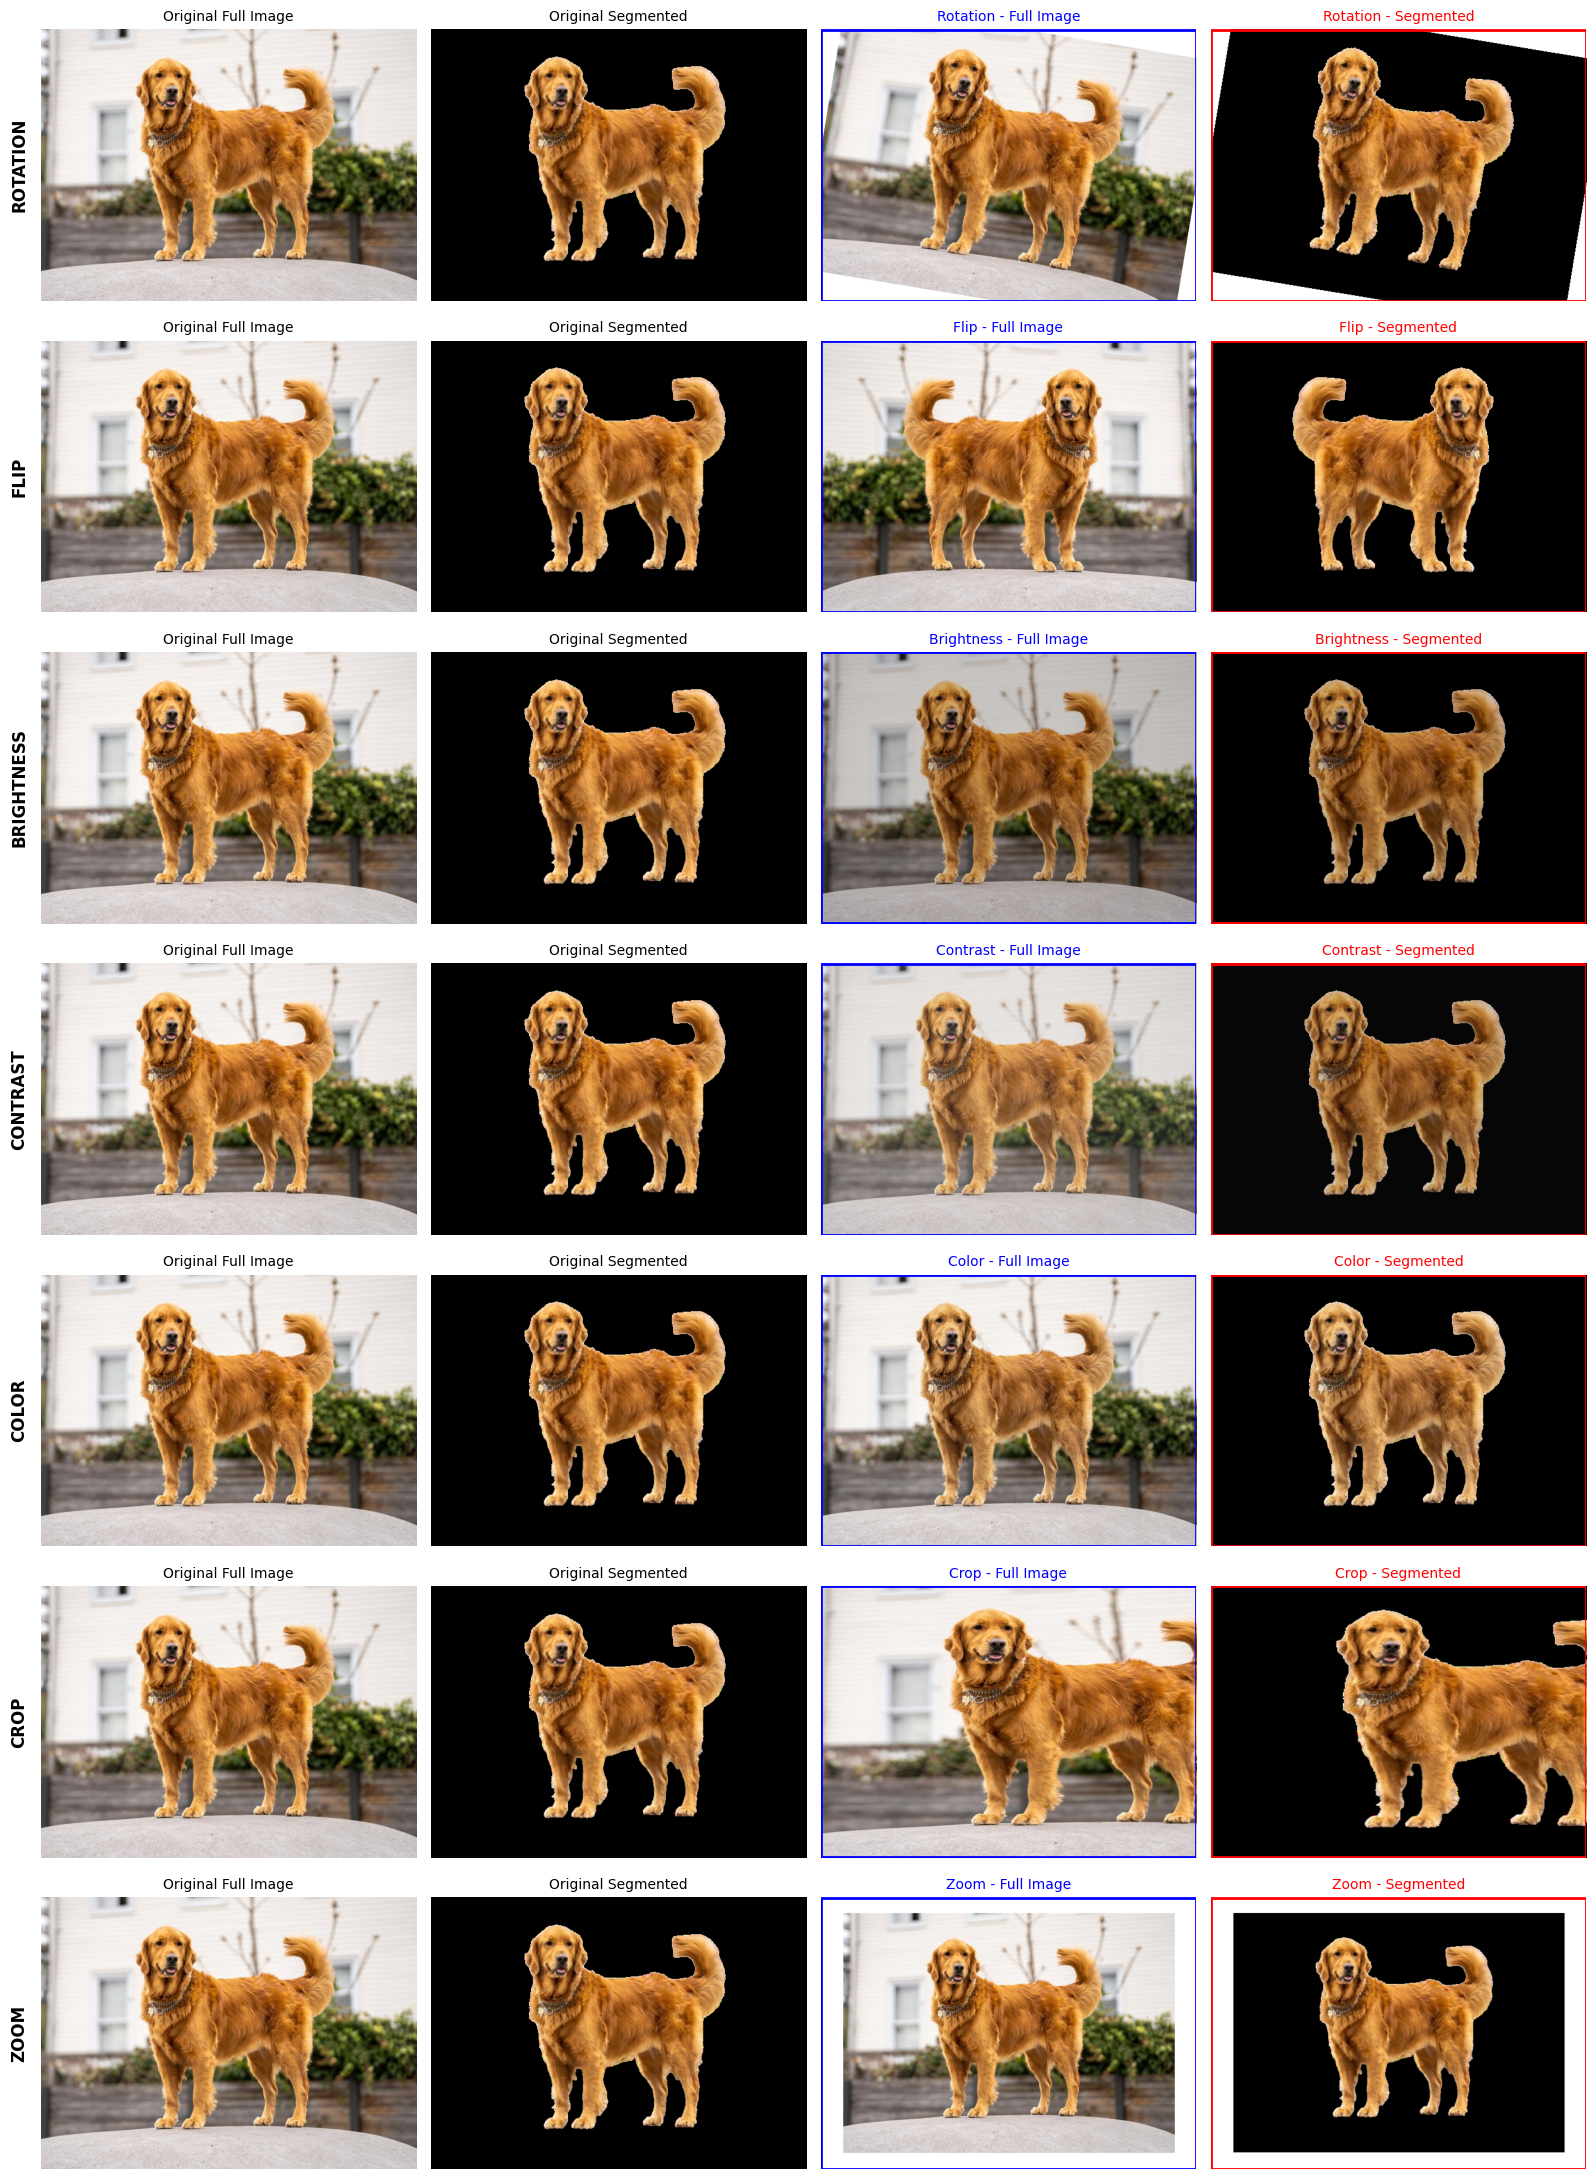

🎯 Key Insight: Both views receive the SAME augmentation parameters!
   → This maintains correspondence while adding diversity
   → Teacher (segmented) provides clean supervision
   → Student (full) learns to extract relevant features despite distractions


In [7]:
# Visualize Two-View Augmentation Comparison

def dual_view_augmentation(full_img, seg_img, aug_type, intensity=0.7):
    """Apply the same augmentation parameters to both views."""
    
    # Set same random seed for consistent augmentation
    random.seed(123)
    aug_full = apply_augmentations(full_img, aug_type, intensity)
    
    random.seed(123)  # Reset to same seed
    aug_seg = apply_augmentations(seg_img, aug_type, intensity)
    
    return aug_full, aug_seg

# Test different augmentation types
if 'full_image' in locals() and 'segmented_image' in locals():
    
    augmentation_types = ['rotation', 'flip', 'brightness', 'contrast', 'color', 'crop', 'zoom']
    
    fig, axes = plt.subplots(len(augmentation_types), 4, figsize=(16, 22))
    
    for i, aug_type in enumerate(augmentation_types):
        # Apply same augmentation to both views
        aug_full, aug_seg = dual_view_augmentation(full_image, segmented_image, aug_type)
        
        # Original images
        axes[i, 0].imshow(full_image)
        axes[i, 0].set_title(f'Original Full Image', fontsize=10)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(segmented_image)
        axes[i, 1].set_title(f'Original Segmented', fontsize=10)
        axes[i, 1].axis('off')
        
        # Augmented images
        axes[i, 2].imshow(aug_full)
        axes[i, 2].set_title(f'{aug_type.title()} - Full Image', fontsize=10, color='blue')
        axes[i, 2].axis('off')
        axes[i, 2].add_patch(plt.Rectangle((0, 0), aug_full.width-1, aug_full.height-1, 
                                          fill=False, edgecolor='blue', linewidth=2))
        
        axes[i, 3].imshow(aug_seg)
        axes[i, 3].set_title(f'{aug_type.title()} - Segmented', fontsize=10, color='red')
        axes[i, 3].axis('off')
        axes[i, 3].add_patch(plt.Rectangle((0, 0), aug_seg.width-1, aug_seg.height-1, 
                                          fill=False, edgecolor='red', linewidth=2))
        
        # Add row label
        axes[i, 0].text(-50, aug_full.height//2, f'{aug_type.upper()}', 
                       rotation=90, fontsize=12, fontweight='bold', ha='center', va='center')
    
    # plt.suptitle('DualViewHair: Consistent Augmentations Across Both Views', 
    #              fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("🎯 Key Insight: Both views receive the SAME augmentation parameters!")
    print("   → This maintains correspondence while adding diversity")
    print("   → Teacher (segmented) provides clean supervision")  
    print("   → Student (full) learns to extract relevant features despite distractions")
    
else:
    print("❌ Images not loaded. Please run the previous cell first.")

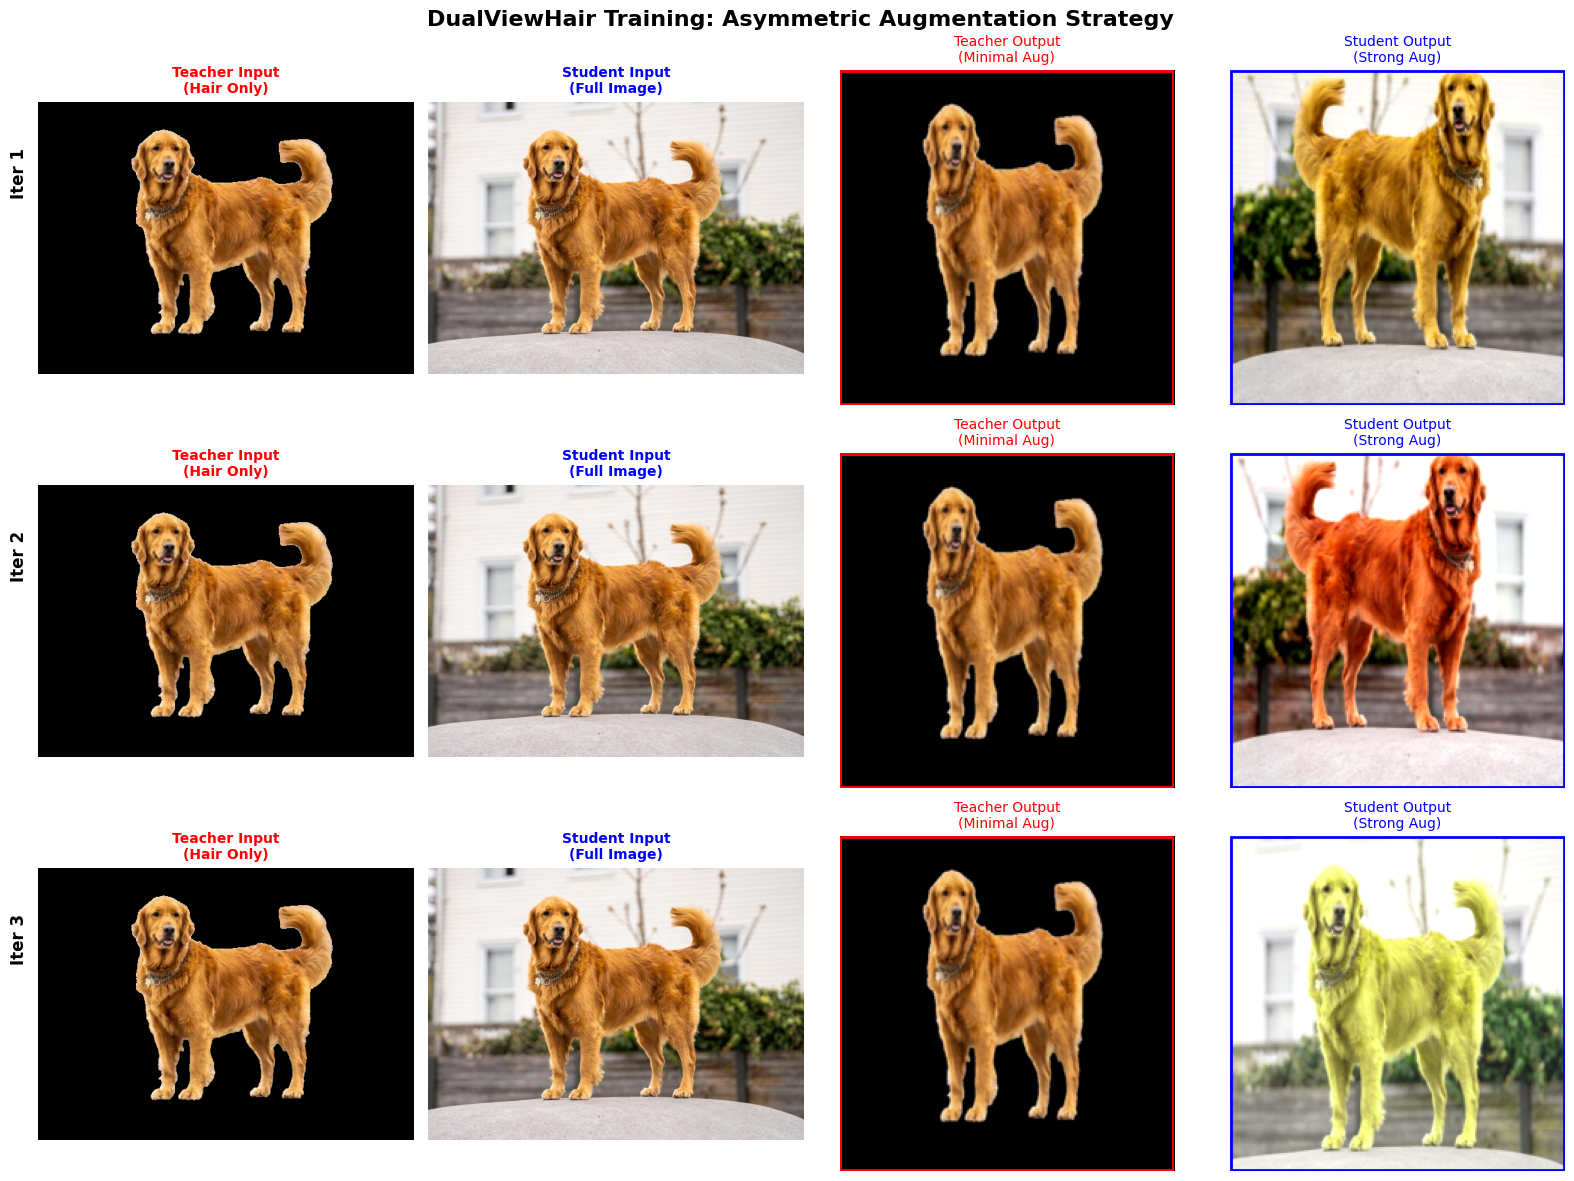

🎓 Training Strategy:
   📍 Teacher (Red): Minimal augmentation for stable supervision
   📍 Student (Blue): Strong augmentation for robustness
   📍 Contrastive Loss: Aligns teacher-student representations
   📍 Result: Student learns to extract hair features from full images!


In [5]:
# Apply DualViewHair Training Augmentations (PyTorch Style)

# Define transforms similar to actual training pipeline
teacher_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

student_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Larger size for crop
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

def tensor_to_image(tensor):
    """Convert tensor back to PIL image for visualization."""
    return transforms.ToPILImage()(tensor)

if 'full_image' in locals() and 'segmented_image' in locals():
    
    # Apply transforms multiple times to show variation
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    for i in range(3):
        # Set different seed for each row to show variation
        torch.manual_seed(i * 10)
        
        # Teacher: minimal augmentation (consistent)
        teacher_tensor = teacher_transform(segmented_image)
        teacher_img = tensor_to_image(teacher_tensor)
        
        # Student: strong augmentation (variable)
        student_tensor = student_transform(full_image)
        student_img = tensor_to_image(student_tensor)
        
        # Display original images
        axes[i, 0].imshow(segmented_image)
        axes[i, 0].set_title('Teacher Input\n(Hair Only)', fontsize=10, color='red', fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(full_image)
        axes[i, 1].set_title('Student Input\n(Full Image)', fontsize=10, color='blue', fontweight='bold')
        axes[i, 1].axis('off')
        
        # Display augmented versions
        axes[i, 2].imshow(teacher_img)
        axes[i, 2].set_title(f'Teacher Output\n(Minimal Aug)', fontsize=10, color='red')
        axes[i, 2].axis('off')
        axes[i, 2].add_patch(plt.Rectangle((0, 0), 223, 223, 
                                          fill=False, edgecolor='red', linewidth=2))
        
        axes[i, 3].imshow(student_img)
        axes[i, 3].set_title(f'Student Output\n(Strong Aug)', fontsize=10, color='blue')
        axes[i, 3].axis('off')
        axes[i, 3].add_patch(plt.Rectangle((0, 0), 223, 223, 
                                          fill=False, edgecolor='blue', linewidth=2))
        
        # Add iteration label
        axes[i, 0].text(-30, 112, f'Iter {i+1}', rotation=90, fontsize=12, 
                       fontweight='bold', ha='center', va='center')
    
    plt.suptitle('DualViewHair Training: Asymmetric Augmentation Strategy', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("🎓 Training Strategy:")
    print("   📍 Teacher (Red): Minimal augmentation for stable supervision")
    print("   📍 Student (Blue): Strong augmentation for robustness")
    print("   📍 Contrastive Loss: Aligns teacher-student representations")
    print("   📍 Result: Student learns to extract hair features from full images!")
    
else:
    print("❌ Images not loaded. Please run the image loading cell first.")

🔍 Demonstrating zoom effects on segmented object:


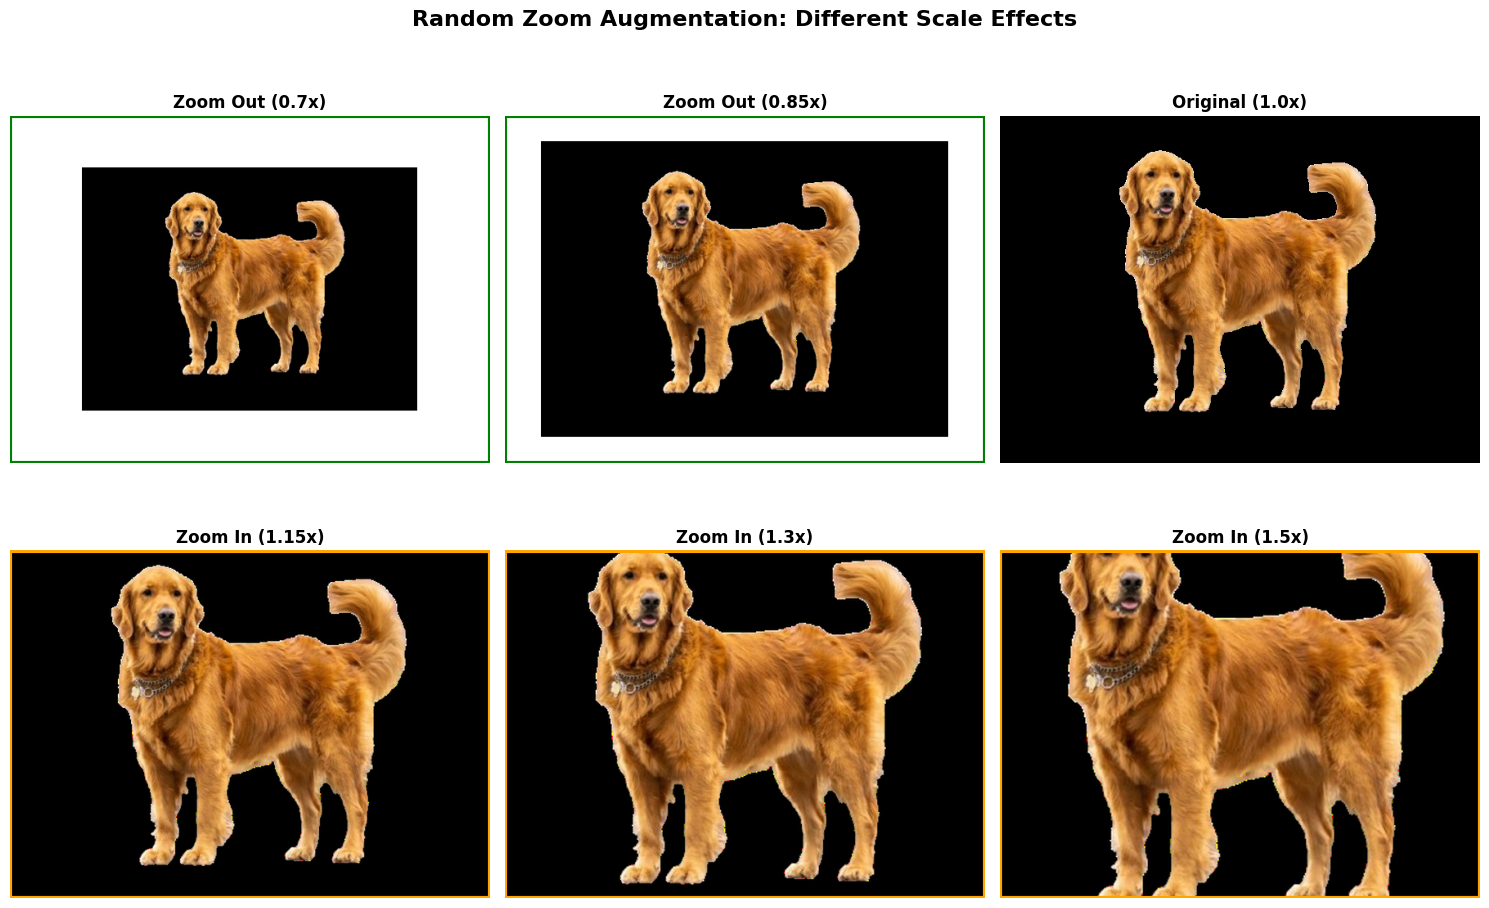


📋 Zoom Augmentation Benefits:
   🟢 Zoom Out: Simulates objects at different distances
   🟠 Zoom In: Focuses on object details, crops background
   ⚫ Original: Baseline for comparison
   🎯 Training Effect: Model learns scale invariance


In [6]:
# Detailed Random Zoom Demonstration

def show_zoom_variations(image, num_variations=6):
    """Show different zoom levels applied to an image."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    zoom_factors = [0.7, 0.85, 1.0, 1.15, 1.3, 1.5]  # Various zoom levels
    
    for i, zoom_factor in enumerate(zoom_factors):
        w, h = image.size
        
        if zoom_factor == 1.0:
            # Original image
            result = image
            title = "Original (1.0x)"
        elif zoom_factor > 1.0:
            # Zoom in: resize larger then center crop
            new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
            zoomed = image.resize((new_w, new_h), Image.LANCZOS)
            
            # Center crop back to original size
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            result = zoomed.crop((left, top, left + w, top + h))
            title = f"Zoom In ({zoom_factor}x)"
        else:
            # Zoom out: resize smaller then pad with white
            new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
            zoomed = image.resize((new_w, new_h), Image.LANCZOS)
            
            # Create white background and paste zoomed image in center
            result = Image.new('RGB', (w, h), (255, 255, 255))
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            result.paste(zoomed, (left, top))
            title = f"Zoom Out ({zoom_factor}x)"
        
        axes[i].imshow(result)
        axes[i].set_title(title, fontsize=12, fontweight='bold')
        axes[i].axis('off')
        
        # Add border color based on zoom type
        if zoom_factor < 1.0:
            color = 'green'  # Zoom out
        elif zoom_factor > 1.0:
            color = 'orange'  # Zoom in
        else:
            color = 'black'  # Original
            
        axes[i].add_patch(plt.Rectangle((0, 0), result.width-1, result.height-1, 
                                       fill=False, edgecolor=color, linewidth=3))
    
    plt.suptitle('Random Zoom Augmentation: Different Scale Effects', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

if 'segmented_image' in locals():
    print("🔍 Demonstrating zoom effects on segmented object:")
    show_zoom_variations(segmented_image)
    
    print("\n📋 Zoom Augmentation Benefits:")
    print("   🟢 Zoom Out: Simulates objects at different distances")
    print("   🟠 Zoom In: Focuses on object details, crops background")
    print("   ⚫ Original: Baseline for comparison")
    print("   🎯 Training Effect: Model learns scale invariance")
else:
    print("❌ Segmented image not loaded. Please run the image loading cell first.")